In [1]:
!pip install sentencepiece pandas regex matplotlib scipy transformers emoji nltk senticnet pandarallel

In [5]:
VOCAB_SIZE = 40000
MAX_LEN = 512
BATCH_SIZE = 1
EMBED_SIZE = 512
HIDDEN_SIZE = 512
NUM_HEADS = 16
NUM_LAYERS = 5
DROPOUT = 0.15
EPOCHS = 16
OUTPUT_SIZE = 30
USE_BERT = True
FEATURES_COUNT = 16 + 25
DATASET = 'dataset/personality.csv'

# Explore data

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

dfd = pd.read_csv(DATASET).drop('user_id', axis=1).drop('Unnamed: 0', axis=1)

In [7]:
dfd.columns = [
    'message',
    "Anxiety",
    "Anger",
    "Depression",
    "Shyness",
    "Immoderation",
    "Vulnerability",
    "Friendliness",
    "Sociability",
    "Assertiveness",
    "Activity Level",
    "Desire for Admiration",
    "Energy",
    "Imagination",
    "Interest in Art",
    "Emotionality",
    "Adventurousness",
    "Intellect",
    "Liberalism",
    "Trust",
    "Sincerity",
    "Altruism",
    "Cooperation",
    "Modesty",
    "Empathy",
    "Self-Confidence",
    "Integrity",
    "Sense of Duty",
    "Striving for Achievements",
    "Self-Discipline",
    "Caution",
]

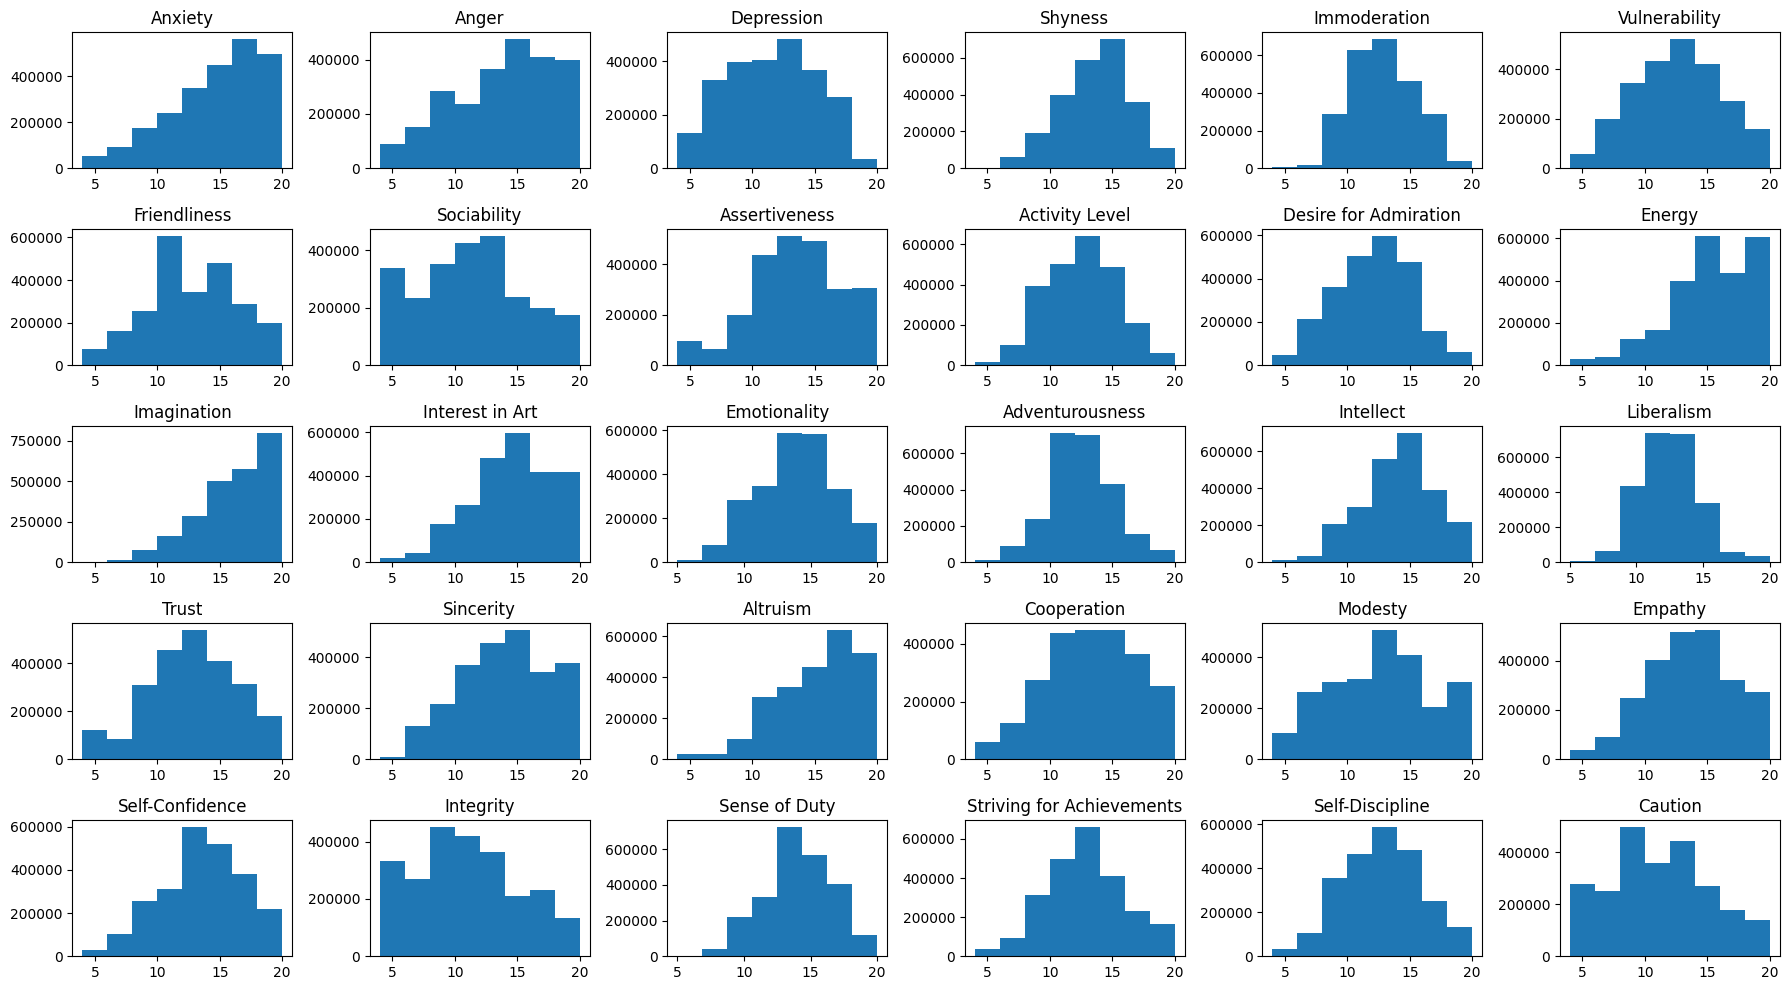

In [9]:
fig, ax = plt.subplots(5, 6, figsize=(18, 10))
dfd.hist(ax=ax, bins=8, grid=False)
plt.tight_layout()
plt.show()

<Axes: >

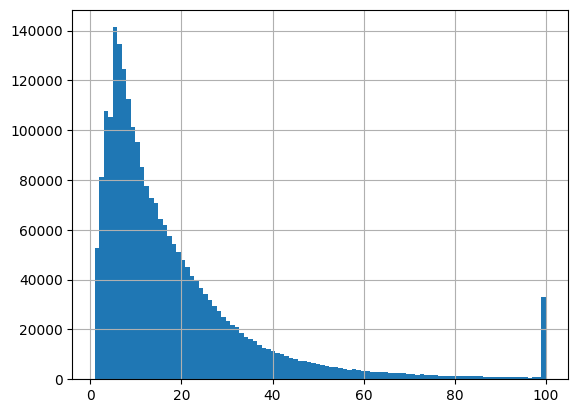

In [7]:
dfd['len'] = dfd['message'].str.len()
dfd['len'].clip(upper=100).hist(bins=100)

# Prepare dataset

In [47]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [48]:
from senticnet.babelsenticnet import BabelSenticNet

sn = BabelSenticNet('ru')
import re

def keep_letters_only(text):
    return re.sub(r'[^a-zA-Zа-яА-ЯёЁ ]', '', text)


def average_senticnet_polarity(text):
    words = keep_letters_only(text.lower()).split()
    polarities = []
    for word in words:
        try:
            polarity = float(sn.concept(word)[0])
            polarities.append(polarity)
        except KeyError:
            continue
    return sum(polarities) / (len(polarities) + 1e-5)

In [49]:
import numpy as np

def senticnet_features(text):
    words = keep_letters_only(text.lower()).split()

    metrics = dict(    
        polarities = [],
        pleasantness = [],
        attention = [],
        sensitivity = [],
        aptitude = [],
    )
    
    for word in words:
        try:
            concept = sn.concept(word)
            metrics['polarities'].append(float(concept['polarity_value']))
            metrics['pleasantness'].append(float(concept['sentics']['pleasantness']))
            metrics['attention'].append(float(concept['sentics']['attention']))
            metrics['sensitivity'].append(float(concept['sentics']['sensitivity']))
            metrics['aptitude'].append(float(concept['sentics']['aptitude']))
        except KeyError:
            continue

    funcs = {
        'avg': np.mean,
        'max': np.max,
        'min': np.min,
        'std': np.std,
        'median': np.median,
    }

    out = {}
    for k, v in metrics.items():
        for fname, f in funcs.items():
            if len(v) == 0:
                j = 0
            else:
                try:
                    j = f(v)
                except ValueError:
                    j = 0

            if np.isnan(j):
                j = 0
            out[f'{fname}_{k}'] = j

    return out

In [50]:
 len(senticnet_features('Всем привет, как у вас дела?)'))

25

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

In [52]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
import random

from nltk.corpus import stopwords
stop_words = set(stopwords.words("russian"))

In [53]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [54]:
def lower(s):
    return str(s).lower()

In [55]:
from transformers import DistilBertTokenizer
from emoji import demojize

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-multilingual-cased")

def encode_text(sentence, tokenizer, max_len=50):
    encoded = tokenizer(
        demojize(sentence),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )
    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]
    return input_ids.squeeze()#, attention_mask.squeeze()


tokenizer_func = lambda text: encode_text(text, tokenizer, MAX_LEN)

print(tokenizer_func("привет. как дела?",))

tensor([  101, 10913, 41102,   119, 10949, 25195,   136,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [56]:
from torch.utils.data import Dataset
import torch
import pandas as pd
import regex
import re
import numpy as np
from nltk.tokenize import sent_tokenize
from tqdm import tqdm

tqdm.pandas()

features_cached = None

class TranslationDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_messages_per_user=50):
        self.tokenizer = tokenizer
        df = pd.read_csv(csv_file)
        print(df.head(15))

        # Filter invalid messages
        df = df[df['message'].apply(lambda row: isinstance(row, str))]
        df.drop_duplicates(subset=["message"], keep=False, inplace=True)
        df = df[df['message'].apply(lambda row: len(row) > 10)]
        searchfor = ['@', 'http', 't.me']
        df = df[~df['message'].str.contains('|'.join(searchfor))]
        df.reset_index(drop=True, inplace=True)

        self.max_messages_per_user = max_messages_per_user

        self.user_ids = df['user_id'].tolist()
        self.messages = df['message'].apply(lower).tolist()

        # --- Feature Engineering
        global features_cached
        if features_cached is None:
            self.features = pd.DataFrame()
            self.features['message_length'] = df['message'].progress_apply(lambda text: len(text))
            self.features['letter_count'] = df['message'].progress_apply(lambda text: len(regex.findall(r'\p{L}', text)))
            self.features['emoji_count'] = df['message'].progress_apply(lambda text: len(regex.findall(r'\p{Emoji}', text)))
            self.features['punctuation_count'] = df['message'].progress_apply(lambda text: len([c for c in text if c in '.,!?;:']))
            self.features['capital_count'] = df['message'].progress_apply(lambda text: sum(1 for c in text if c.isupper()))
            self.features['char_repeats'] = df['message'].progress_apply(lambda t: len(re.findall(r'(.)\1{2,}', t)))
            self.features['num_sentences'] = df['message'].progress_apply(lambda t: len(sent_tokenize(t)))
            negations = ['не', 'нет', 'ни', 'никогда', 'нельзя']
            self.features['negation_count'] = df['message'].progress_apply(lambda t: sum(word in t.lower() for word in negations))
            self.features['is_question'] = df['message'].progress_apply(lambda t: int('?' in t))
            self.features['is_exclamation'] = df['message'].progress_apply(lambda t: int('!' in t))
            self.features['avg_word_len'] = df['message'].progress_apply(lambda t: np.mean([len(w) for w in t.split()]) if t.split() else 0)
            bad_words = set(['бля', 'сука', 'хуй', 'пизд'])
            self.features['swear_count'] = df['message'].progress_apply(lambda t: sum(word in t.lower() for word in bad_words))
    
            self.features['emoji_ratio'] = self.features['letter_count'] / (self.features['emoji_count'] + 1e-5)
            self.features['punct_ratio'] = self.features['letter_count'] / (self.features['punctuation_count'] + 1e-5)
            self.features['capital_ratio'] = self.features['capital_count'] / (self.features['letter_count'] + 1e-5)
            self.features['stopword_ratio'] = df['message'].parallel_apply(
                lambda t: sum(word in t.lower().split() for word in stop_words) / (len(t.split()) + 1e-5)
            )
    
            # Sentic features
            sentic_features = df['message'].parallel_apply(senticnet_features)
            sentic_features_df = pd.DataFrame(list(sentic_features))
            self.features = pd.concat([self.features, sentic_features_df], axis=1)

            self.features_mean_before_norm = self.features.mean()
            self.features_stdd_before_norm = self.features.std()
    
            # Normalize
            self.features = (self.features - self.features.mean()) / self.features.std()
            features_cached = self.features
        else:
            self.features = features_cached

        print(self.features.head(20))

        # --- Labels
        df_labels = df.iloc[:, 3:]#.drop(columns=['user_id'])
        print(df_labels.columns)

        if OUTPUT_SIZE == 5:
            df2 = pd.DataFrame()
            for trait in 'OCEAN':
                scores = df_labels[[f'{trait}{x}' for x in range(1, 7)]].sum(axis=1)
                df2[trait] = scores
            df_labels = df2

        self.labels = pd.DataFrame()
        for trait in df_labels.columns:
            self.labels[trait] = pd.qcut(df_labels[trait], q=2, labels=[0, 1]).astype(int)

        # Group and chunk messages by user
        self.users = self.group_and_chunk_messages(df)

    def group_and_chunk_messages(self, df):
        """
        Group messages by user_id, then split into chunks of max_messages_per_user.
        """
        grouped = df.groupby('user_id')
        users = []

        for user_id, group in grouped:
            msgs = group['message'].apply(lower).tolist()
            feats = self.features.loc[group.index].values
            lbls = self.labels.loc[group.index].values

            # Split into chunks of max_messages_per_user
            for start_idx in range(0, len(msgs), self.max_messages_per_user):
                end_idx = start_idx + self.max_messages_per_user
                chunk_msgs = msgs[start_idx:end_idx]
                chunk_feats = feats[start_idx:end_idx]
                chunk_lbls = lbls[start_idx:end_idx]

                users.append((chunk_msgs, chunk_feats, chunk_lbls))

        return users

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        messages, features, labels = self.users[idx]

        # Tokenize
        input_ids = []
        for i in range(self.max_messages_per_user):
            try:
                m = messages[i]
            except IndexError:
                m =  ''
            #print(m)
            tokenized = self.tokenizer(m)
            input_ids.append(tokenized)#['input_ids']      # (num_messages, seq_len)
        #attention_mask = tokenized['attention_mask']

        if len(features) < self.max_messages_per_user:
            for i in range(self.max_messages_per_user - len(features)):
                features = np.concatenate((features, np.array([[0] * 41])))
                #features.append([0] * 41)

        features = torch.tensor(features, dtype=torch.float)  # (num_messages, feature_dim)
        label = torch.tensor(labels[0], dtype=torch.float)    # Pick first label (they should all be the same)

        return torch.stack(input_ids), features, label


In [57]:
# seed
import random
import numpy as np
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

SEED = 42
set_seed(SEED)

In [58]:
from torch.utils.data import random_split

# Create dataloader
train_dataset = TranslationDataset(DATASET, tokenizer_func, max_messages_per_user=35)
train_data, test_data = random_split(train_dataset, [0.9, 0.1], generator=torch.Generator().manual_seed(SEED))

# Print the lengths of the train and validation sets
print("Number of training samples:", len(train_data))
print("Number of test samples:", len(test_data))

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=True)

    Unnamed: 0    user_id                                            message  \
0            0  228269632  Как хорошо, что Рома и медведь ни с чем плохим...   
1            1  228269632  Так мило, что вы это обсуждаете в чате, но ник...   
2            2  228269632                                    Hello, Kitty ❤️   
3            3  228269632                       Ты не в её вкусе, старикашка   
4            4  228269632  Мужчина медведь: \nЕбанутый демон? Ммммм.....б...   
5            5  228269632         @Li1Daenerys а у тебя какая группа крови?🤔   
6            6  228269632                                                I +   
7            7  228269632                                       С яицами....   
8            8  228269632                                                  А   
9            9  228269632                                           Вибрисы?   
10          10  228269632  А надо меньше позволять всяким заюшам кровь св...   
11          11  228269632               

100%|█████████████████████████████████████████████████████████████████████| 1011614/1011614 [00:01<00:00, 616141.52it/s]


    message_length  letter_count  emoji_count  punctuation_count  \
0         0.474078      0.440579     0.100146           0.067803   
1         0.730698      0.707498     0.100146           0.208086   
2        -0.055201     -0.072729    -0.069513           0.067803   
3         0.345768      0.296853    -0.069513           0.909503   
4        -0.311821     -0.380713    -0.069513           0.488653   
5         0.345768      0.399514    -0.069513          -0.072481   
6        -0.295782     -0.319116    -0.069513          -0.072481   
7        -0.151433     -0.134325    -0.069513          -0.072481   
8        -0.231627     -0.236987     0.100146          -0.072481   
9         1.195822      1.200273    -0.069513           0.208086   
10       -0.055201     -0.093261    -0.069513          -0.072481   
11       -0.071239     -0.052196    -0.069513          -0.072481   
12        0.201419      0.214724    -0.069513           0.067803   
13        0.297652      0.358450    -0.069513   

In [19]:
train_dataset.features_mean_before_norm, train_dataset.features_stdd_before_norm

(message_length         3.144171e+01
 letter_count           2.554216e+01
 emoji_count            4.097225e-01
 punctuation_count      5.166724e-01
 capital_count          1.707706e+00
 char_repeats           7.600626e-02
 num_sentences          1.070528e+00
 negation_count         4.240530e-01
 is_question            7.667055e-02
 is_exclamation         1.356842e-02
 avg_word_len           5.289971e+00
 swear_count            4.459705e-02
 emoji_ratio            1.982929e+06
 punct_ratio            1.514966e+06
 capital_ratio          3.439236e+00
 stopword_ratio         3.310461e-01
 avg_polarities         3.767020e-02
 max_polarities         1.337462e-01
 min_polarities        -6.247957e-02
 std_polarities         8.842343e-02
 median_polarities      4.051658e-02
 avg_pleasantness       4.688662e-02
 max_pleasantness       1.509873e-01
 min_pleasantness      -5.934306e-02
 std_pleasantness       9.454969e-02
 median_pleasantness    4.813477e-02
 avg_attention         -3.623782e-02
 

In [20]:
train_dataset.__getitem__(21_020)

(tensor([[  101,   541, 59371,  ...,     0,     0,     0],
         [  101,   549, 12999,  ...,     0,     0,     0],
         [  101, 10122,   571,  ...,     0,     0,     0],
         ...,
         [  101, 10405, 79141,  ...,     0,     0,     0],
         [  101,   554, 10227,  ...,     0,     0,     0],
         [  101, 12123,   560,  ...,     0,     0,     0]]),
 tensor([[-0.1194, -0.1138, -0.0695,  ...,  2.1314, -0.4714,  2.2130],
         [-0.1675, -0.1754, -0.0695,  ...,  2.0621, -0.4714,  2.1317],
         [ 0.4741,  0.5022, -0.0695,  ..., -1.9039,  1.6295, -2.5210],
         ...,
         [-0.3118, -0.3191, -0.0695,  ...,  0.1515, -0.4714, -0.1097],
         [ 1.3562,  1.3029,  0.6091,  ..., -1.8241,  2.2711, -0.7968],
         [ 1.1477,  1.0360,  0.4395,  ..., -1.8241,  2.8161,  0.6736]]),
 tensor([0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.]))

# Define model

In [21]:
import torch.nn as nn

In [22]:
def detect_nan(n, tensor):
    try:
        if torch.isnan(tensor).any():
            print(n, 'DETECTED NAN')
    except Exception as e:
        print(n, f'Unable to detect NAN: {e}')

In [23]:
import torch
import torch.nn as nn
from transformers import DistilBertModel, AutoModel

class AttentionPooling(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.attention_vector = nn.Linear(input_dim, 1)

    def forward(self, x, mask=None):
        scores = self.attention_vector(x).squeeze(-1)  # (batch_size, seq_len)
    
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -torch.inf)

        attn_weights = torch.softmax(scores, dim=-1)
    
        # If softmax fails (NaNs), replace with uniform
        attn_weights = torch.where(
            torch.isnan(attn_weights),
            torch.full_like(attn_weights, 1.0 / attn_weights.size(1)),
            attn_weights
        )
    
        context = torch.bmm(attn_weights.unsqueeze(1), x).squeeze(1)
        return context

class PersonalityAnalyzer(nn.Module):
    def __init__(
        self,
        features_dim,       # Number of handcrafted features
        output_size=30,      # Number of output traits
        dropout_prob=0.2,   # Dropout
        model_name='distilbert-base-multilingual-cased',
    ):
        super().__init__()

        self.use_bert = True
        self.distilbert = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.distilbert.config.hidden_size

        # Attention over tokens (inside each message)
        self.token_attention = AttentionPooling(self.hidden_size)

        # Attention over messages (across all messages for one user)
        self.message_attention = AttentionPooling(self.hidden_size + features_dim)

        # Dropout
        self.dropout = nn.Dropout(dropout_prob)

        # Final prediction head
        self.fc_out = nn.Sequential(
            nn.LayerNorm(self.hidden_size + features_dim),
            nn.Linear(self.hidden_size + features_dim, 512),
            nn.GELU(),
            nn.Dropout(dropout_prob),
            nn.Linear(512, output_size)
        )
        #self.fc_out = nn.Linear(self.hidden_size + features_dim, output_size)  # experiment

    def encode_one_message(self, input_tokens, attention_mask, features):
        #outputs = self.distilbert(input_tokens, attention_mask=attention_mask)
        # Detect completely empty (padding only) sequences
        empty_sequences = (attention_mask.sum(dim=1) == 0)

        if empty_sequences.any():
            print(f"Warning: {empty_sequences.sum()} empty sequences detected!")
            input_tokens[empty_sequences, 0] = 101  # CLS token
            attention_mask[empty_sequences, 0] = 1

        outputs = self.distilbert(input_tokens, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state  # (batch_size, seq_len, hidden_size)
        pooled = self.token_attention(hidden_states, attention_mask)  # (batch_size, hidden_size)

        # Concatenate with handcrafted features
        x = torch.cat([pooled, features], dim=-1)  # (batch_size, hidden_size + features_dim)
        x = self.dropout(x)
        return x

    def forward(self, input_tokens, features):
        """
        input_tokens: (batch_size, num_messages, seq_len)
        attention_masks: (batch_size, num_messages, seq_len)
        features: (batch_size, num_messages, features_dim)
        """

        batch_size, num_messages, seq_len = input_tokens.shape

        # Flatten messages for parallel encoding
        input_tokens = input_tokens.view(batch_size * num_messages, seq_len)
        attention_masks = (input_tokens != 0).long()
        features = features.view(batch_size * num_messages, -1)

        # Encode each message separately
        message_embeddings = self.encode_one_message(input_tokens, attention_masks, features)
        message_embeddings = message_embeddings.view(batch_size, num_messages, -1)

        # Pool across messages to get final user representation
        user_embedding = self.message_attention(message_embeddings)

        # Final prediction
        outputs = self.fc_out(user_embedding)
        
        return outputs


In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PersonalityAnalyzer(FEATURES_COUNT).to(device)
model

PersonalityAnalyzer(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (li

In [25]:
def check_nan(module, inp, out):
    if torch.isnan(out).any() or torch.isinf(out).any():
        raise RuntimeError(f'NAN in {module.__class__.__name__}')

for m in model.modules():
    if isinstance(m, (nn.Linear, nn.MultiheadAttention)):
        m.register_forward_hook(check_nan)

In [23]:
# Initialize weights for model
import torch.nn.init as init

def init_weights(m):
    if isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)

model.token_attention.apply(init_weights)
model.message_attention.apply(init_weights)
model.fc_out.apply(init_weights)

torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
# torch.nn.utils.clip_grad_norm_(model.message_attention.parameters(), max_norm=1.0)
# torch.nn.utils.clip_grad_norm_(model.fc_out.parameters(), max_norm=1.0)

tensor(0.)

In [26]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

135,167,387 total parameters.
135,167,387 training parameters.



In [41]:
from tqdm import tqdm


def calculate_traits_for_text(text, features):
    with torch.no_grad():
        text = text.to(device).unsqueeze(0) if text.dim() == 1 else text
        features = features.to(device).unsqueeze(0) if features.dim() == 1 else features

        score = model(text, features).to(device)
    return score#.cpu().detach().numpy()[0]


def logits_to_result(traits):
    probs = torch.sigmoid(traits)#.cpu().detach().numpy()
    return (probs > 0.5).long()#.cpu().detach().numpy()[0]


def calculate_accuracy(model_output, desired):
    #probs = torch.sigmoid(model_output)
    logits = logits_to_result(model_output)

    correct = (logits == desired).sum().item()
    total = desired.numel()

    return correct / total


def calculate_accuracy_on_test_set(model, device, feature_disable_idx=-1, zero_features=False):
    acc_probes = []
    for text, features, traits in tqdm(test_loader):
        inputs = text.to(device)
        if not zero_features:
            features = features.to(device)
        else:
            features = torch.zeros_like(features).to(device)

        targets = traits.to(device).long()

        if feature_disable_idx >= 0:
            features = features.clone()
            features[:, feature_disable_idx] = 0

        model.eval()
        with autocast('cuda'), torch.no_grad():
            logits = model(inputs, features)

        acc = calculate_accuracy(logits, targets)
        acc_probes.append(acc)

    return sum(acc_probes) / len(acc_probes) # avg


# Predict output for test samples and display
def test_model(model, samples=None):
    pass

# Train model

In [28]:
## 

from torch.amp import GradScaler, autocast
from IPython.display import display
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import numpy
from scipy.stats import linregress
from transformers import get_cosine_schedule_with_warmup


def diversity_loss(logits):
    batch_var = torch.var(logits, dim=0).mean()
    if torch.isnan(batch_var):
        return 1.0
    batch_var = torch.clamp(batch_var, min=1e-3)  # prevent near-zero
    return 1.0 / (batch_var + 1e-5)


class Trainer:
    def __init__(
        self,
        model,
        device,
        data,
        calculate_accuracy,
        calculate_accuracy_on_test_set,
        epochs=16,
        lr=1e-4,
        criterion_override=None,
    ) -> None:
        self.model = model
        if USE_BERT:
            self.optimizer = torch.optim.AdamW([
                {'params': model.distilbert.parameters(), 'lr': 2e-5},   # smaller LR for pretrained BERT
                {'params': model.fc_out.parameters(), 'lr': 1e-4},        # larger LR for custom head
                {'params': model.token_attention.parameters(), 'lr': 1e-4},
                {'params': model.message_attention.parameters(), 'lr': 1e-4},
            ], weight_decay=1e-6)
        else:
            self.optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-6)
        
        total_steps = 427696
        warmup_steps = int(0.1 * total_steps)

        self.scheduler = get_cosine_schedule_with_warmup(
            self.optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps,
        )

        #self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer, step_size=2, gamma=0.8)
        
        # Different loss strategies have been tested
        #self.criterion = nn.MSELoss()
        #self.criterion = nn.CrossEntropyLoss()
        #self.criterion = nn.L1Loss()
        self.criterion = nn.BCEWithLogitsLoss()
        self.device = device
        self.epochs = epochs
        self.scaler = GradScaler()

        self.current_epoch = 0
        self.loss_history = []
        self.global_step = 0
        self.local_step = 0
        self.data = data
        self._data_loader = []
        self.total_loss = 0
        self.loss_history_avg = []

        self.min_loss = float("inf")
        self.max_loss = float("-inf")
        self.x_epochs = []
        self.was_started = False
        self.loss_by_epochs = {}
        self.accuracy = []
        self.accuracy_on_test_set_x = []
        self.accuracy_on_test_set_y = []
        self.acc_by_epochs = {}

        self.calculate_accuracy_on_test_set = calculate_accuracy_on_test_set
        self.calculate_accuracy = calculate_accuracy

    def _plot(self, mean_loss):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 4))
        # Plot loss
        
        #with plt.style.context('Solarize_Light2'):
        ax1.plot(
            self.loss_history_avg,
            linestyle="-",
            color="b",
            label="Loss",
        )
        #plt.plot(linregress(), '--k')
        m, b, *_ = linregress(range(len(self.loss_history_avg)), self.loss_history_avg)
        ax1.axline(xy1=(0, b), slope=m, label=f'$y = {m:.3f}x {b:+.3f}$', linestyle='--')
        #plt.axhline(y=0.693, color="y", linestyle="-", label="0.693")
        ax1.axhline(y=mean_loss, color="g", linestyle="-", label="Mean Loss")
        ax1.vlines(
            x=self.x_epochs,
            ymin=0,
            ymax=1,
            color="r",
            linestyle="-",
            label="Epochs",
        )
        ax1.set_xlabel("Iterations")
        ax1.set_ylabel("Loss")
        ax1.set_title("Training Loss Over Time")
        ax1.legend()
        ax1.grid()

        # Plot accuracy
        ax2.plot(
            self.accuracy,
            linestyle="-",
            color="g",
            label="Accuracy over Sample",
        )
        ax2.plot(
            self.accuracy_on_test_set_x,
            self.accuracy_on_test_set_y,
            linestyle="-",
            marker='o',
            color="r",
            label="Accuracy on Test Set",
        )
        ax2.axhline(y=0.5, color="y", linestyle="-", label="0.5")
        ax1.set_ylabel("Accuracy")
        ax2.set_title("Accuracy")
        ax2.legend()
        ax2.grid()
        last_acc = self.accuracy[-1]
        try:
            last_acc_test = self.accuracy_on_test_set_y[-1]
            ax2.annotate('%0.2f' % last_acc_test, xy=(1, last_acc_test), xytext=(8, 0), 
                                    xycoords=('axes fraction', 'data'), textcoords='offset points', color="red")
        except IndexError:
            pass
        ax2.annotate('%0.2f' % last_acc, xy=(1, last_acc), xytext=(8, 0), 
                         xycoords=('axes fraction', 'data'), textcoords='offset points')

        plt.tight_layout()
        plt.show()

    def _mean_loss_last(self) -> float:
        return sum(self.loss_history[-50:]) / (50 if len(self.loss_history) >= 50 else len(self.loss_history))

    def render_info(self):
        mean_loss = self._mean_loss_last()
        self._plot(mean_loss)

        print(f"Epoch [{self.current_epoch+1}/{self.epochs}]")
        ls = self.local_step
        ldl = len(self.data)

        print(f"Epoch progress [{round(ls/ldl*100,1)}%] {ls}/{ldl}")
        print(
            f"Total progress [{round(self.global_step/(ldl*self.epochs)*100,1)}%] {self.global_step}/{ldl*self.epochs}"
        )
        print(f"Mean loss: {mean_loss}")

        for epoch, loss in self.loss_by_epochs.items():
            print(f"Epoch {epoch+1}/{self.epochs}, Loss: {loss:.4f}, Accuracy: {self.acc_by_epochs[epoch]:.4f}")

        test_model(model)

        self.model.train()

    def train(self, update_freq=100):
        self.model.train()
        self.model.to(self.device)

        if not self.was_started:
            self._data_loader = enumerate(self.data)
        self.was_started = True

        for epoch in range(self.current_epoch, self.epochs):
            self.current_epoch = epoch

            for i, (text, features, traits) in self._data_loader:
                self.optimizer.zero_grad()
                inputs = text.to(self.device)
                features = features.to(self.device)
                targets = traits.to(self.device)#.long()

                with autocast('cuda'):
                    logits = self.model(inputs, features)
                    #loss = sum(self.criterion(logits[:, i], targets[:, i]) for i in range(OUTPUT_SIZE)) / OUTPUT_SIZE
                    loss = self.criterion(logits, targets)
                    #print(logits, targets)
                    loss = loss + 0.01 * diversity_loss(logits)
                    #print(diversity_loss(logits))

                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                #loss.backward()
                #self.optimizer.step()
                
                self.total_loss += loss.item()
                self.loss_history.append(loss.item())
                self.loss_history_avg.append(self._mean_loss_last())
                self.global_step += 1
                self.local_step = i

                if loss.item() < self.min_loss:
                    self.min_loss = loss.item()
                if loss.item() > self.max_loss:
                    self.max_loss = loss.item()

                # 🔥 Update graph every `update_freq` iterations
                if self.global_step % update_freq == 0:
                    # Calculate accuracy
                    clear_output(wait=True)
                    acc = self.calculate_accuracy(logits, targets)
                    print(f'Accuracy: {acc* 100:.2f}%')
                    self.accuracy.append(acc)
                    self.render_info()

                # Calculate Test Set Accuracy
                if (self.global_step + 9_500) % 10_000 == 0:
                    acc_test = self.calculate_accuracy_on_test_set(self.model, self.device)
                    print(f'Accuracy on Test Set: {acc_test * 100:.2f}%')
                    self.accuracy_on_test_set_x.append(len(self.accuracy)-1)
                    self.accuracy_on_test_set_y.append(acc_test)

                self.scheduler.step()

            self.x_epochs.append(self.global_step)
            avg_loss = self.total_loss / self.global_step
            self.loss_by_epochs[self.current_epoch] = avg_loss
            self.acc_by_epochs[self.current_epoch] = sum(self.accuracy) / len(self.accuracy)
            self._data_loader = enumerate(self.data)

In [29]:
trainer = Trainer(model, device, train_loader, calculate_accuracy, calculate_accuracy_on_test_set)

Accuracy: 83.33%


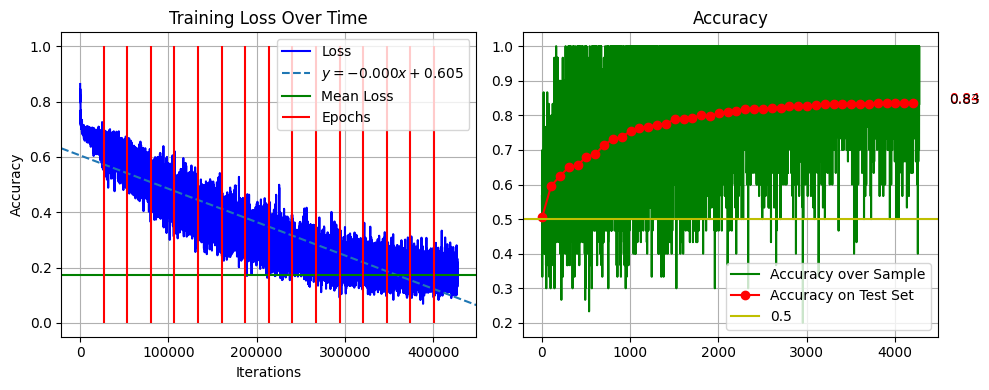

Epoch [16/16]
Epoch progress [99.6%] 26634/26731
Total progress [100.0%] 427600/427696
Mean loss: 0.17417727271094918
Epoch 1/16, Loss: 0.6744, Accuracy: 0.5935
Epoch 2/16, Loss: 0.6416, Accuracy: 0.6154
Epoch 3/16, Loss: 0.6097, Accuracy: 0.6434
Epoch 4/16, Loss: 0.5785, Accuracy: 0.6679
Epoch 5/16, Loss: 0.5494, Accuracy: 0.6908
Epoch 6/16, Loss: 0.5228, Accuracy: 0.7100
Epoch 7/16, Loss: 0.4982, Accuracy: 0.7264
Epoch 8/16, Loss: 0.4755, Accuracy: 0.7423
Epoch 9/16, Loss: 0.4544, Accuracy: 0.7561
Epoch 10/16, Loss: 0.4348, Accuracy: 0.7672
Epoch 11/16, Loss: 0.4167, Accuracy: 0.7792
Epoch 12/16, Loss: 0.3999, Accuracy: 0.7899
Epoch 13/16, Loss: 0.3847, Accuracy: 0.8003
Epoch 14/16, Loss: 0.3709, Accuracy: 0.8086
Epoch 15/16, Loss: 0.3585, Accuracy: 0.8159


In [28]:
trainer.train(update_freq=100)

# Save/load model

In [30]:
# Saving the model
def save_model(model, optimizer, scheduler, filepath, only_model=False):
    torch.save({
        'model_state_dict': model.state_dict(),
    }, filepath + '.pth')
    print(f"Model saved to {filepath}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
    }, filepath + '_for_training.pth')
    print(f"Model saved to {filepath}_for_training.pth")

# Loading the model
def load_model(model, optimizer, scheduler, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    print(f"Model loaded from {filepath}")

def load_model_only(model, filepath):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model loaded from {filepath}")

In [31]:
# save_model(model, trainer.optimizer, trainer.scheduler, 'personality_30_final')

Model saved to personality_30_final.pth
Model saved to personality_30_final_for_training.pth


In [31]:
load_model_only(model, 'personality_30_final.pth')

Model loaded from personality_30_final.pth


# Calculate metrics

In [34]:
pip install scikit-learn

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 6.6 MB/s eta 0:00:0000:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [32]:
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics_on_data(model, device, loader, feature_disable_idx=-1, zero_features=False, average='macro'):
    y_preds = []
    y_trues = []

    for text, features, traits in tqdm(loader):
        inputs = text.to(device)

        if not zero_features:
            features = features.to(device)
        else:
            features = torch.zeros_like(features).to(device)

        targets = traits.to(device).long()

        if feature_disable_idx >= 0:
            features = features.clone()
            features[:, feature_disable_idx] = 0

        model.eval()
        with autocast('cuda'), torch.no_grad():
            logits = model(inputs, features)

        y_pred = logits_to_result(logits).cpu()
        y_true = targets.cpu()

        y_preds.append(y_pred)
        y_trues.append(y_true)

    y_preds = torch.cat(y_preds, dim=0).numpy()
    y_trues = torch.cat(y_trues, dim=0).numpy()

    # Per-class accuracy
    per_class_acc = (y_preds == y_trues).mean(axis=0)
    avg_class_acc = per_class_acc.mean()

    return {
        'f1_micro': f1_score(y_trues, y_preds, average='micro', zero_division=0),
        'f1_macro': f1_score(y_trues, y_preds, average='macro', zero_division=0),
        'subset_accuracy': accuracy_score(y_trues, y_preds),
        'per_class_accuracy': per_class_acc,
        'avg_class_accuracy': avg_class_acc
    }

In [59]:
calculate_metrics_on_data(model, device, test_loader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 743/743 [02:52<00:00,  4.31it/s]


{'f1_micro': 0.8115986695945859,
 'f1_macro': 0.809642193093755,
 'subset_accuracy': 0.432996632996633,
 'per_class_accuracy': array([0.84983165, 0.83771044, 0.83164983, 0.83771044, 0.83501684,
        0.83636364, 0.83569024, 0.83198653, 0.84107744, 0.83501684,
        0.84915825, 0.83939394, 0.81414141, 0.83434343, 0.82996633,
        0.81952862, 0.86801347, 0.83198653, 0.82491582, 0.83973064,
        0.82491582, 0.83838384, 0.84006734, 0.83602694, 0.82424242,
        0.82659933, 0.83400673, 0.83703704, 0.84040404, 0.83535354]),
 'avg_class_accuracy': np.float64(0.8353423120089786)}

In [62]:
calculate_metrics_on_data(model, device, test_loader, zero_features=True)

100%|███████████████████████████████████████████████████████████████████████████| 743/743 [02:47<00:00,  4.45it/s]


{'f1_micro': 0.8070319940284677,
 'f1_macro': 0.804757353730716,
 'subset_accuracy': 0.4255892255892256,
 'per_class_accuracy': array([0.84175084, 0.83569024, 0.83097643, 0.83400673, 0.83569024,
        0.83198653, 0.83569024, 0.83063973, 0.83569024, 0.83131313,
        0.84242424, 0.83569024, 0.81144781, 0.82861953, 0.82626263,
        0.81616162, 0.85723906, 0.82929293, 0.82323232, 0.83636364,
        0.82255892, 0.83265993, 0.84175084, 0.83097643, 0.81986532,
        0.82424242, 0.82794613, 0.83737374, 0.83434343, 0.82962963]),
 'avg_class_accuracy': np.float64(0.8317171717171716)}

# Build xgboost model on features

In [39]:
pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 3.0 MB/s eta 0:00:0000:0100:02
Note: you may need to restart the kernel to use updated packages.


In [63]:
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Subset
from tqdm import tqdm

In [64]:
def prepare_xgb_data(dataset):
    """
    Принимает dataset или Subset, возвращает:
      X: np.array, shape (n_samples, feature_dim)
      y: np.array, shape (n_samples, n_traits)
    """
    X_list = []
    y_list = []
    for _, feats, labels in tqdm(dataset):
        feats_np = feats.numpy()
        labels_np = labels.numpy()

        X_list.append(feats_np.mean(axis=0))
        y_list.append(labels_np)

    X = np.vstack(X_list)
    y = np.vstack(y_list)
    return X, y

X_train, y_train = prepare_xgb_data(train_data)
X_test,  y_test  = prepare_xgb_data(test_data)

traits = ['O','C','E','A','N']
results = {}

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2970/2970 [00:30<00:00, 98.54it/s]


O | Accuracy: 0.6650 | F1-score: 0.5508


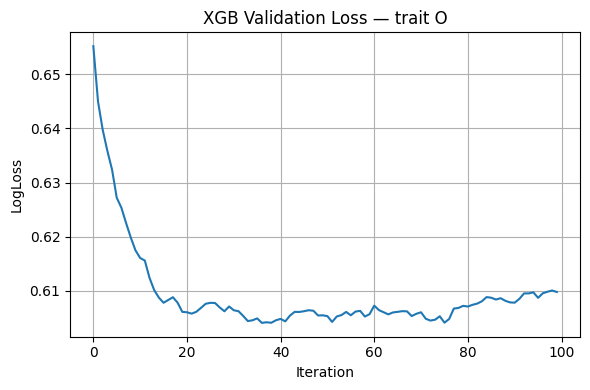

C | Accuracy: 0.6626 | F1-score: 0.5790


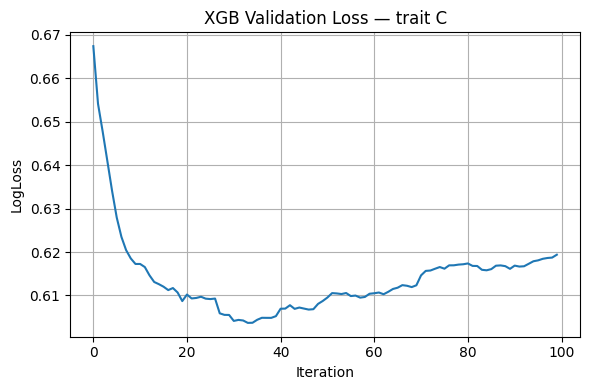

E | Accuracy: 0.6498 | F1-score: 0.6046


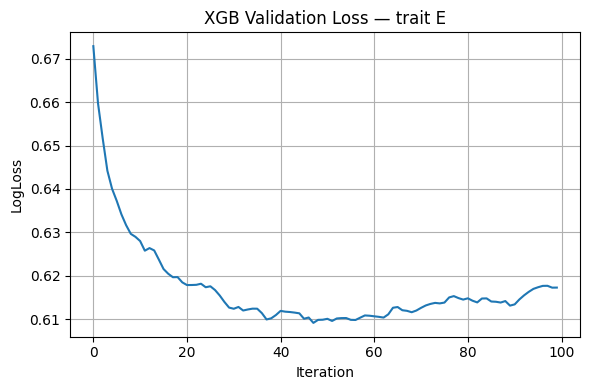

A | Accuracy: 0.6562 | F1-score: 0.6381


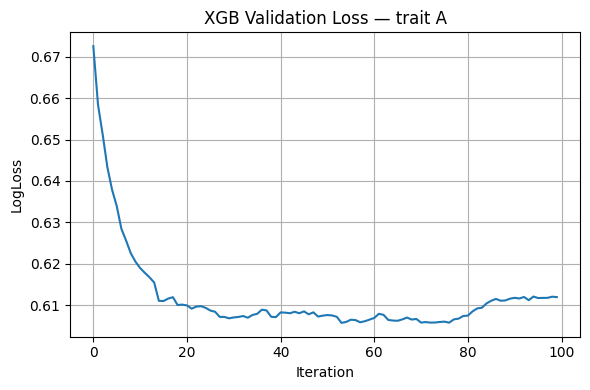

N | Accuracy: 0.6993 | F1-score: 0.4359


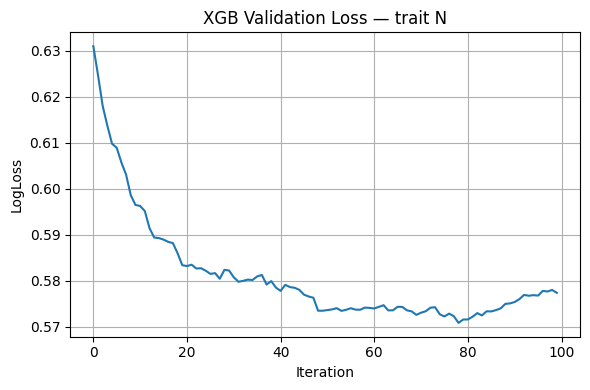


Summary:
    Accuracy  F1-score
O  0.664983  0.550790
C  0.662626  0.578992
E  0.649832  0.604563
A  0.656229  0.638072
N  0.699327  0.435881

Avg:
 Accuracy    0.666599
F1-score    0.561659
dtype: float64


In [67]:
leaves = []

for idx, trait in enumerate(traits):
    xgb_clf = xgb.XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        random_state=SEED
    )

    xgb_clf.fit(
        X_train, 
        y_train[:, idx], 
        eval_set=[(X_test, y_test[:, idx])],
        verbose=False
    )

    evals_result = xgb_clf.evals_result()

    y_pred = xgb_clf.predict(X_test)

    acc = accuracy_score(y_test[:, idx], y_pred)
    f1  = f1_score(y_test[:, idx], y_pred, zero_division=0)
    results[trait] = {'accuracy': acc, 'f1': f1, 'evals_result': evals_result}

    # Number of trees
    num_trees = xgb_clf.get_booster().num_boosted_rounds()
    
    # Number of leaves per tree (on average)
    booster = xgb_clf.get_booster()
    trees_dump = booster.get_dump()
    
    total_leaves = 0
    for tree in trees_dump:
        total_leaves += tree.count('leaf')
    
    leaves.append(total_leaves)

    print(f"{trait} | Accuracy: {acc:.4f} | F1-score: {f1:.4f}")

    plt.figure(figsize=(6,4))
    plt.plot(evals_result['validation_0']['logloss'], label='logloss')
    plt.title(f"XGB Validation Loss — trait {trait}")
    plt.xlabel("Iteration")
    plt.ylabel("LogLoss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df_results = pd.DataFrame({
    trait: {
        'Accuracy': results[trait]['accuracy'],
        'F1-score': results[trait]['f1']
    }
    for trait in traits
}).T
print("\nSummary:\n", df_results)
print("\nAvg:\n", df_results.mean())

In [68]:
leaves, sum(leaves)

([4876, 4999, 4962, 5084, 5004], 24925)

# Try rubert-tiny model

In [63]:
from torch.utils.data import random_split

from transformers import AutoTokenizer
from emoji import demojize

model_name = "cointegrated/rubert-tiny"
tokenizer_1 = AutoTokenizer.from_pretrained(model_name)

def encode_text_1(sentence, tokenizer, max_len=50):
    encoded = tokenizer(
        demojize(sentence),
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt",
    )
    input_ids = encoded["input_ids"]
    attention_mask = encoded["attention_mask"]
    return input_ids.squeeze()#, attention_mask.squeeze()


tokenizer_func_1 = lambda text: encode_text_1(text, tokenizer_1, MAX_LEN)

print(tokenizer_func_1("привет. как дела?",))

# Create dataloader
train_dataset_1 = TranslationDataset(DATASET, tokenizer_func_1, max_messages_per_user=35)
train_data_1, test_data_1 = random_split(train_dataset_1, [0.9, 0.1], generator=torch.Generator().manual_seed(SEED))

# Print the lengths of the train and validation sets
print("Number of training samples:", len(train_data_1))
print("Number of test samples:", len(test_data_1))

train_loader_1 = DataLoader(train_data_1, batch_size=BATCH_SIZE, shuffle=True)
test_loader_1 = DataLoader(test_data_1, batch_size=4, shuffle=True)

tokenizer_config.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/632 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/241k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/468k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tensor([    2,  1129, 13167,    18,  1150,  7843,    35,     3,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

In [75]:
model_1 = PersonalityAnalyzer(FEATURES_COUNT, model_name='cointegrated/rubert-tiny').to(device)
model_1

PersonalityAnalyzer(
  (distilbert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(29564, 312, padding_idx=0)
      (position_embeddings): Embedding(512, 312)
      (token_type_embeddings): Embedding(2, 312)
      (LayerNorm): LayerNorm((312,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-2): 3 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=312, out_features=312, bias=True)
              (key): Linear(in_features=312, out_features=312, bias=True)
              (value): Linear(in_features=312, out_features=312, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=312, out_features=312, bias=True)
              (LayerNorm): LayerNorm((312,), eps=1e-12, e

In [76]:
model_1.token_attention.apply(init_weights)
model_1.message_attention.apply(init_weights)
model_1.fc_out.apply(init_weights)

torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)

tensor(0.)

In [77]:
# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in model_1.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model_1.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.\n")

11,982,179 total parameters.
11,982,179 training parameters.



In [78]:
trainer_1 = Trainer(model_1, device, train_loader_1, calculate_accuracy, lambda model, device: float(calculate_metrics_on_data(model, device, test_loader_1)['avg_class_accuracy']))

Accuracy: 53.33%


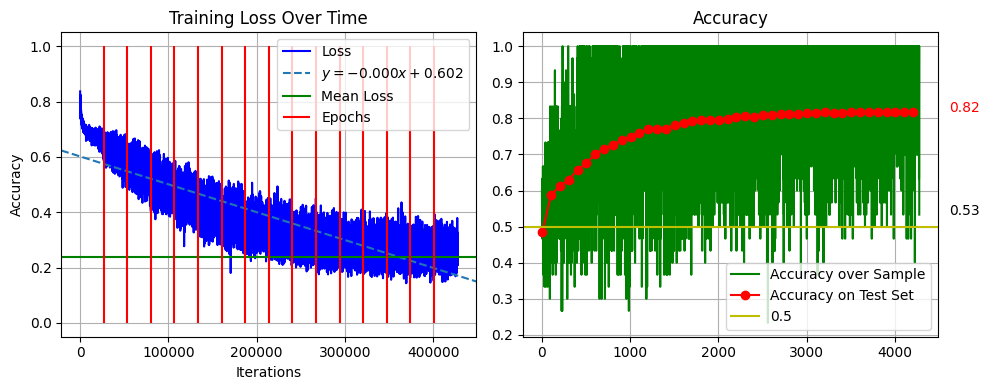

Epoch [16/16]
Epoch progress [99.6%] 26634/26731
Total progress [100.0%] 427600/427696
Mean loss: 0.2368286909908056
Epoch 1/16, Loss: 0.6852, Accuracy: 0.5859
Epoch 2/16, Loss: 0.6529, Accuracy: 0.6179
Epoch 3/16, Loss: 0.6197, Accuracy: 0.6492
Epoch 4/16, Loss: 0.5886, Accuracy: 0.6726
Epoch 5/16, Loss: 0.5604, Accuracy: 0.6935
Epoch 6/16, Loss: 0.5349, Accuracy: 0.7074
Epoch 7/16, Loss: 0.5120, Accuracy: 0.7249
Epoch 8/16, Loss: 0.4915, Accuracy: 0.7386
Epoch 9/16, Loss: 0.4729, Accuracy: 0.7527
Epoch 10/16, Loss: 0.4561, Accuracy: 0.7632
Epoch 11/16, Loss: 0.4410, Accuracy: 0.7733
Epoch 12/16, Loss: 0.4274, Accuracy: 0.7806
Epoch 13/16, Loss: 0.4152, Accuracy: 0.7878
Epoch 14/16, Loss: 0.4044, Accuracy: 0.7942
Epoch 15/16, Loss: 0.3947, Accuracy: 0.8005


In [79]:
trainer_1.train(update_freq=100)

In [80]:
calculate_metrics_on_data(model_1, device, test_loader_1)

100%|███████████████████████████████████████████████████████████████████████████| 743/743 [02:03<00:00,  6.02it/s]


{'f1_micro': 0.7904682795140692,
 'f1_macro': 0.7885652437498584,
 'subset_accuracy': 0.36397306397306395,
 'per_class_accuracy': array([0.82154882, 0.82087542, 0.82222222, 0.81582492, 0.83569024,
        0.82828283, 0.81346801, 0.81750842, 0.81784512, 0.80976431,
        0.83434343, 0.83063973, 0.80875421, 0.8010101 , 0.81683502,
        0.7952862 , 0.84949495, 0.81245791, 0.80639731, 0.83265993,
        0.82154882, 0.83367003, 0.82525253, 0.81245791, 0.7969697 ,
        0.80673401, 0.80740741, 0.81010101, 0.83569024, 0.82356902]),
 'avg_class_accuracy': np.float64(0.8188103254769923)}

In [81]:
calculate_metrics_on_data(model_1, device, test_loader_1, zero_features=True)

100%|███████████████████████████████████████████████████████████████████████████| 743/743 [02:06<00:00,  5.89it/s]


{'f1_micro': 0.7831649568982331,
 'f1_macro': 0.7810532132726394,
 'subset_accuracy': 0.3464646464646465,
 'per_class_accuracy': array([0.82087542, 0.81851852, 0.81986532, 0.81144781, 0.82592593,
        0.82424242, 0.81414141, 0.81515152, 0.81447811, 0.8030303 ,
        0.82693603, 0.81750842, 0.8       , 0.79292929, 0.80875421,
        0.79124579, 0.84882155, 0.8023569 , 0.796633  , 0.82558923,
        0.81380471, 0.82895623, 0.82053872, 0.7952862 , 0.79427609,
        0.8020202 , 0.7993266 , 0.80909091, 0.83030303, 0.81279461]),
 'avg_class_accuracy': np.float64(0.8128282828282827)}

# Mask N messages and get metrics

In [33]:
def masked_loader(base_loader, keep_first_n: int):
    for msg, fts, lbl in base_loader:
        # msg: (BATCH_SIZE, 35, 512)
        # fts: (BATCH_SIZE, 35, feature_dim)

        B, seq_len, dim = msg.shape
        mask_msg = torch.zeros_like(msg)
        mask_fts = torch.zeros_like(fts)

        # Insert 101 and 102 in first two columns of msg
        mask_msg[:, :, 0] = 101
        mask_msg[:, :, 1] = 102

        # Copy original data for first N rows
        mask_msg[:, :keep_first_n] = msg[:, :keep_first_n]
        mask_fts[:, :keep_first_n] = fts[:, :keep_first_n]

        yield mask_msg, mask_fts, lbl

In [182]:
msgs_metrics = []

for i in [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 35]:
    metrics = calculate_metrics_on_data(model, device, masked_loader(test_loader, i))
    m = {
        'messages_limit': i,
        'accuracy': float(metrics['avg_class_accuracy']),
        'f1_micro': metrics['f1_micro'],
        'f1_macro': metrics['f1_macro'],
    }
    print(m)
    msgs_metrics.append(m)

743it [02:47,  4.42it/s]


{'messages_limit': 1, 'accuracy': 0.5550841750841751, 'f1_micro': 0.3589171356491364, 'f1_macro': 0.2785978794285188}


743it [02:45,  4.49it/s]


{'messages_limit': 2, 'accuracy': 0.5684960718294053, 'f1_micro': 0.40084776138010564, 'f1_macro': 0.3498242201138397}


743it [02:47,  4.45it/s]


{'messages_limit': 3, 'accuracy': 0.5839281705948373, 'f1_micro': 0.4445809486710814, 'f1_macro': 0.4089838804647311}


743it [02:48,  4.41it/s]


{'messages_limit': 5, 'accuracy': 0.6138496071829406, 'f1_micro': 0.5078247932938518, 'f1_macro': 0.48639523488062014}


743it [02:46,  4.45it/s]


{'messages_limit': 7, 'accuracy': 0.6454882154882156, 'f1_micro': 0.5620762799983363, 'f1_macro': 0.5483133447001212}


743it [02:50,  4.36it/s]


{'messages_limit': 10, 'accuracy': 0.6845005611672279, 'f1_micro': 0.6215586758390437, 'f1_macro': 0.6136490922495665}


743it [02:52,  4.30it/s]


{'messages_limit': 15, 'accuracy': 0.7429517396184061, 'f1_micro': 0.6997469814758976, 'f1_macro': 0.6950919513183258}


743it [02:49,  4.39it/s]


{'messages_limit': 20, 'accuracy': 0.7820089786756453, 'f1_micro': 0.7483969584310272, 'f1_macro': 0.7454131162502642}


743it [02:47,  4.42it/s]


{'messages_limit': 25, 'accuracy': 0.8073512906846241, 'f1_micro': 0.7785875524024508, 'f1_macro': 0.7763844314984899}


743it [02:49,  4.39it/s]


{'messages_limit': 30, 'accuracy': 0.8257351290684625, 'f1_micro': 0.8003651465086079, 'f1_macro': 0.7981717007532929}


743it [02:51,  4.33it/s]

{'messages_limit': 35, 'accuracy': 0.8353423120089786, 'f1_micro': 0.8115986695945859, 'f1_macro': 0.809642193093755}


<Axes: xlabel='messages_limit'>

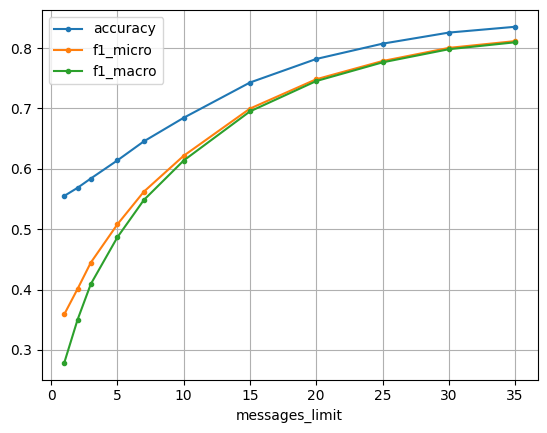

In [185]:
df_metrics = pd.DataFrame(msgs_metrics)
df_metrics.plot(x='messages_limit', grid=True, style='.-')

# Limit max length of messages and get metrics

In [194]:
def limit_tokens_in_dataset(dataset, max_tokens, final_size=512):
    """
    For each (input_ids, features, labels) in the dataset:
    - Truncate or pad input_ids to max_tokens
    - Always add END token (102) at the end
    - Pad with PAD token (0) up to final_size (512)
    """
    for input_ids, features, labels in dataset:
        input_ids = input_ids.clone()

        # Truncate or pad to max_tokens
        seq_len = input_ids.shape[-1]

        if seq_len > max_tokens:
            input_ids = input_ids[..., :max_tokens]
        elif seq_len < max_tokens:
            pad_length = max_tokens - seq_len
            pad = torch.zeros(*input_ids.shape[:-1], pad_length, dtype=input_ids.dtype, device=input_ids.device)
            input_ids = torch.cat([input_ids, pad], dim=-1)

        # Ensure END token at the end of each sentence
        input_ids[..., max_tokens - 1] = 102

        # Pad to final_size (512) if needed
        if max_tokens < final_size:
            pad_length = final_size - max_tokens
            pad = torch.zeros(*input_ids.shape[:-1], pad_length, dtype=input_ids.dtype, device=input_ids.device)
            input_ids = torch.cat([input_ids, pad], dim=-1)

        yield (input_ids, features, labels)

In [202]:
msgs_metrics1 = []

for i in [5, 7, 10, 15, 20, 25, 35, 50, 100, 150, 200, 300, 512]:
    metrics = calculate_metrics_on_data(model, device, limit_tokens_in_dataset(test_loader, i))
    m = {
        'length_limit': i,
        'accuracy': float(metrics['avg_class_accuracy']),
        'f1_micro': metrics['f1_micro'],
        'f1_macro': metrics['f1_macro'],
    }
    print(m)
    msgs_metrics1.append(m)

743it [02:48,  4.41it/s]


{'length_limit': 5, 'accuracy': 0.6420875420875422, 'f1_micro': 0.5506425431180251, 'f1_macro': 0.53247321303632}


743it [02:47,  4.43it/s]


{'length_limit': 7, 'accuracy': 0.7022671156004489, 'f1_micro': 0.6409603984516687, 'f1_macro': 0.6319204792022866}


743it [02:47,  4.44it/s]


{'length_limit': 10, 'accuracy': 0.7566105499438832, 'f1_micro': 0.7132088446889547, 'f1_macro': 0.7080919125750998}


743it [02:46,  4.45it/s]


{'length_limit': 15, 'accuracy': 0.8039506172839507, 'f1_micro': 0.7726172190257999, 'f1_macro': 0.7693634350901338}


743it [02:44,  4.51it/s]


{'length_limit': 20, 'accuracy': 0.820830527497194, 'f1_micro': 0.7934585726854008, 'f1_macro': 0.7911594843906076}


743it [02:47,  4.45it/s]


{'length_limit': 25, 'accuracy': 0.8263973063973064, 'f1_micro': 0.7998654383604181, 'f1_macro': 0.7975621194024487}


743it [02:47,  4.45it/s]


{'length_limit': 35, 'accuracy': 0.831638608305275, 'f1_micro': 0.8065111119710044, 'f1_macro': 0.8042067940665328}


743it [02:49,  4.39it/s]


{'length_limit': 50, 'accuracy': 0.8337373737373739, 'f1_micro': 0.8088368131726327, 'f1_macro': 0.8066385395090803}


743it [02:50,  4.35it/s]


{'length_limit': 100, 'accuracy': 0.8338047138047137, 'f1_micro': 0.809155583049799, 'f1_macro': 0.8068946815017258}


743it [02:48,  4.41it/s]


{'length_limit': 150, 'accuracy': 0.834915824915825, 'f1_micro': 0.810350829690945, 'f1_macro': 0.8082394100370442}


743it [02:51,  4.34it/s]


{'length_limit': 200, 'accuracy': 0.8344556677890013, 'f1_micro': 0.8093871959887312, 'f1_macro': 0.8072228153776909}


743it [02:46,  4.46it/s]


{'length_limit': 300, 'accuracy': 0.8347923681257016, 'f1_micro': 0.8101820807757776, 'f1_macro': 0.8080777350392236}


743it [02:44,  4.52it/s]

{'length_limit': 512, 'accuracy': 0.7067003367003367, 'f1_micro': 0.6642167885181235, 'f1_macro': 0.6401332885653767}


<Axes: xlabel='length_limit'>

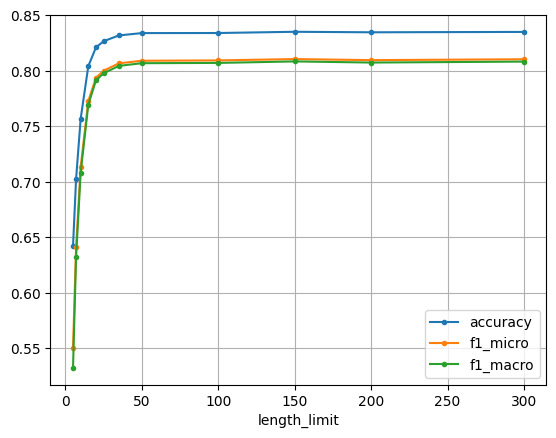

In [204]:
df_metrics1 = pd.DataFrame(msgs_metrics1[:-1])
df_metrics1.plot(x='length_limit', grid=True, style='.-')

# Words-tokens relation

In [37]:
dfd = dfd[~dfd['message'].isnull()]

In [38]:
# среднее количество слов
avg_words = dfd['message'].str.split().apply(len).mean()

In [42]:
# среднее количество токенов
avg_tokens = dfd['message'].parallel_apply(lambda x: int((tokenizer_func(x) != 0).sum())).mean()

In [43]:
avg_words, avg_tokens

(np.float64(3.6210679482564876), np.float64(11.460455711050813))

In [44]:
(avg_tokens - 2) / avg_words

np.float64(2.612614799345574)